In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import  torch, os
import  numpy as np
from    MimicCxrJpg import MimicCxrJpg
import  scipy.stats
from    torch.utils.data import DataLoader
#from    torch.optim import lr_scheduler
#import  random, sys, pickle
import  argparse

from meta import Meta


def mean_confidence_interval(accs, confidence=0.95):
    n = accs.shape[0]
    m, se = np.mean(accs), scipy.stats.sem(accs)
    h = se * scipy.stats.t._ppf((1 + confidence) / 2, n - 1)
    return m, h


def main():

    torch.manual_seed(222)
    torch.cuda.manual_seed_all(222)
    np.random.seed(222)

    print(args)

    config = [
        ('conv2d', [64, 1, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [64, 64, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [64, 64, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [64, 64, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('max_pool2d', [2, 1, 0]),
        ('flatten', []),
        ('linear', [args.n_way, 33856])
    ]

    device = torch.device('cuda')
    maml = Meta(args, config).to(device)

    tmp = filter(lambda x: x.requires_grad, maml.parameters())
    num = sum(map(lambda x: np.prod(x.shape), tmp))
    print(maml)
    print('Total trainable tensors:', num)

    # batchsz here means total episode number
    mini = MimicCxrJpg('../../../../scratch/rl80/mimic-cxr-jpg-2.0.0.physionet.org/files/',
                       mode='train', csv_path='../splits.csv', n_way=args.n_way, k_shot=args.k_spt, k_query=args.k_qry,
                       batchsz=1000, resize=args.imgsz)
    mini_test = MimicCxrJpg('../../../../scratch/rl80/mimic-cxr-jpg-2.0.0.physionet.org/files/',
                            mode='test', csv_path='../splits.csv', n_way=args.n_way, k_shot=args.k_spt, k_query=args.k_qry,
                            batchsz=100, resize=args.imgsz)

    for epoch in range(args.epoch//1000):
        # fetch meta_batchsz num of episode each time
        db = DataLoader(mini, args.task_num, shuffle=True, num_workers=4, pin_memory=True)

        for step, (x_spt, y_spt, x_qry, y_qry) in enumerate(db):

            x_spt, y_spt, x_qry, y_qry = x_spt.to(device), y_spt.to(device), x_qry.to(device), y_qry.to(device)

            accs = maml(x_spt, y_spt, x_qry, y_qry)

            if step % 30 == 0:
                print('step:', step, '\ttraining acc:', accs)

            if step % 100 == 0:  # evaluation
                db_test = DataLoader(mini_test, 1, shuffle=True, num_workers=4, pin_memory=True)
                accs_all_test = []

                for x_spt, y_spt, x_qry, y_qry in db_test:
                    x_spt, y_spt, x_qry, y_qry = x_spt.squeeze(0).to(device), y_spt.squeeze(0).to(device), \
                                                 x_qry.squeeze(0).to(device), y_qry.squeeze(0).to(device)

                    accs = maml.finetunning(x_spt, y_spt, x_qry, y_qry)
                    accs_all_test.append(accs)

                # [b, update_step+1]
                accs = np.array(accs_all_test).mean(axis=0).astype(np.float16)
                print('Test acc:', accs)


if __name__ == '__main__':

    argparser = argparse.ArgumentParser()
    argparser.add_argument('--epoch', type=int, help='epoch number', default=1000)
    argparser.add_argument('--n_way', type=int, help='n way', default=3)
    argparser.add_argument('--k_spt', type=int, help='k shot for support set', default=10)
    argparser.add_argument('--k_qry', type=int, help='k shot for query set', default=10)
    argparser.add_argument('--imgsz', type=int, help='imgsz', default=224)
    argparser.add_argument('--imgc', type=int, help='imgc', default=1)
    argparser.add_argument('--task_num', type=int, help='meta batch size, namely task num', default=1)
    argparser.add_argument('--meta_lr', type=float, help='meta-level outer learning rate', default=1e-3)
    argparser.add_argument('--update_lr', type=float, help='task-level inner update learning rate', default=0.01)
    argparser.add_argument('--update_step', type=int, help='task-level inner update steps', default=5)
    argparser.add_argument('--update_step_test', type=int, help='update steps for finetunning', default=10)

    args, unknown = argparser.parse_known_args()

    main()


Namespace(epoch=1000, imgc=1, imgsz=224, k_qry=10, k_spt=10, meta_lr=0.001, n_way=3, task_num=1, update_lr=0.01, update_step=5, update_step_test=10)
Meta(
  (net): Learner(
    conv2d:(ch_in:1, ch_out:64, k:3x3, stride:1, padding:0)
    relu:(True,)
    bn:(64,)
    max_pool2d:(k:2, stride:2, padding:0)
    conv2d:(ch_in:64, ch_out:64, k:3x3, stride:1, padding:0)
    relu:(True,)
    bn:(64,)
    max_pool2d:(k:2, stride:2, padding:0)
    conv2d:(ch_in:64, ch_out:64, k:3x3, stride:1, padding:0)
    relu:(True,)
    bn:(64,)
    max_pool2d:(k:2, stride:2, padding:0)
    conv2d:(ch_in:64, ch_out:64, k:3x3, stride:1, padding:0)
    relu:(True,)
    bn:(64,)
    max_pool2d:(k:2, stride:1, padding:0)
    flatten:()
    linear:(in:33856, out:3)
    
    (vars): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 64x1x3x3 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (2): Parameter containing: [torch.cuda.FloatTens

KeyboardInterrupt: 

shuffle DB :train, b:2, 3-way, 1-shot, 1-query, resize:224
torch.Size([3, 1, 224, 224])


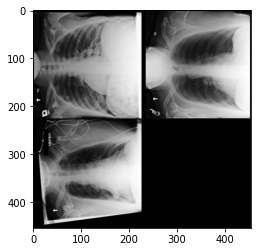

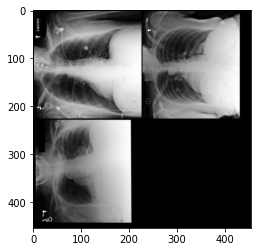

torch.Size([3, 1, 224, 224])


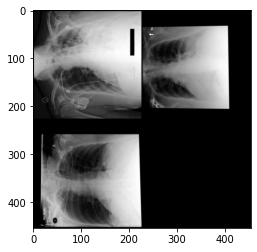

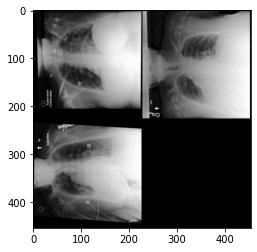

In [4]:
import os
import torch
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import numpy as np
import collections
from PIL import Image
import csv
import random


class MimicCxrJpg(Dataset):
    """
    put mini-imagenet files as :
    root :
        |- images/*.jpg includes all imgeas
        |- train.csv
        |- test.csv
        |- val.csv
    NOTICE: meta-learning is different from general supervised learning, especially the concept of batch and set.
    batch: contains several sets
    sets: conains n_way * k_shot for meta-train set, n_way * n_query for meta-test set.
    """

    def __init__(self, root, mode, csv_path, batchsz, n_way, k_shot, k_query, resize, startidx=0):
        """
        :param root: root path of MIMIC CXR JPG data
        :param mode: base or novel
        :param batchsz: batch size of sets, not batch of imgs
        :param n_way:
        :param k_shot:
        :param k_query: num of qeruy imgs per class
        :param resize: resize to
        :param startidx: start to index label from startidx
        """

        if mode != 'train' and mode != 'test':  # Check if mode contains an accepted value
            raise Exception("Mode must be either train or test")

        self.batchsz = batchsz  # batch of set, not batch of imgs
        self.n_way = n_way  # n-way
        self.k_shot = k_shot  # k-shot
        self.k_query = k_query  # for evaluation
        self.setsz = self.n_way * self.k_shot  # num of samples per set
        self.querysz = self.n_way * self.k_query  # number of samples per set for evaluation
        self.resize = resize  # resize to
        self.startidx = startidx  # index label not from 0, but from startidx
        print('shuffle DB :%s, b:%d, %d-way, %d-shot, %d-query, resize:%d' % (
            mode, batchsz, n_way, k_shot, k_query, resize))

        self.transform = transforms.Compose([lambda x: Image.open(x).convert('L'),
                                             transforms.Resize((self.resize, self.resize)),
                                             transforms.ToTensor()
                                             ])

        self.path = root  # image path
        csvdata = self.loadCSV(csv_path, mode)  # csv path
        self.data = []
        self.img2label = {}
        for i, (k, v) in enumerate(csvdata.items()):
            # sample = []
            # sample.append(v)
            # sample.append(i + self.startidx)
            # self.data.append(sample)
            self.data.append(v)  # [[img1, img2, ...], [img111, ...]]
            self.img2label[k] = i + self.startidx  # {"img_name[:9]":label}
            # print(v)

        self.cls_num = len(self.data)
        self.create_batch(self.batchsz)

    def loadCSV(self, csvf, mode):
        """
        return a dict saving the information of csv
        :param splitFile: csv file name
        :return: {label:[file1, file2 ...]}
        """
        dictLabels = {}
        with open(csvf) as csvfile:
            csvreader = csv.reader(csvfile, delimiter=',')
            next(csvreader, None)  # skip (filename, label)
            for i, row in enumerate(csvreader):
                filename = row[0]
                label = row[1]
                split = row[2]

                # Check for training or testing data
                train_check = (mode == 'train') and ((split == 'base_train') or (split == 'base_validate'))
                test_check = (mode == 'test') and ((split == 'novel_train') or (split == 'novel_validate'))
                if train_check or test_check:
                    # append filename to current label
                    if label in dictLabels.keys():
                        dictLabels[label].append(filename)
                    else:
                        dictLabels[label] = [filename]
        return dictLabels

    def create_batch(self, batchsz):
        """
        create batch for meta-learning.
        ×episode× here means batch, and it means how many sets we want to retain.
        :param episodes: batch size
        :return:
        """
        self.support_x_batch = []  # support set batch
        self.query_x_batch = []  # query set batch
        for b in range(batchsz):  # for each batch
            # 1.select n_way classes randomly
            selected_cls = np.random.choice(self.cls_num, self.n_way, False)  # no duplicate
            np.random.shuffle(selected_cls)
            support_x = []
            query_x = []
            for cls in selected_cls:
                # 2. select k_shot + k_query for each class
                selected_imgs_idx = np.random.choice(len(self.data[cls]), self.k_shot + self.k_query, False)
                np.random.shuffle(selected_imgs_idx)
                indexDtrain = np.array(selected_imgs_idx[:self.k_shot])  # idx for Dtrain
                indexDtest = np.array(selected_imgs_idx[self.k_shot:])  # idx for Dtest

                support_x.append(
                    np.array((self.data[cls], [cls] * len(self.data[cls])))
                        .T[indexDtrain]
                        .tolist()
                )  # get all images filename in [0] for current Dtrain with class in [1]
                query_x.append(
                    np.array((self.data[cls], [cls] * len(self.data[cls])))
                        .T[indexDtest]
                        .tolist()
                )

            # shuffle the correponding relation between support set and query set
            random.shuffle(support_x)
            random.shuffle(query_x)

            self.support_x_batch.append(support_x)  # append set to current sets
            self.query_x_batch.append(query_x)  # append sets to current sets

    def __getitem__(self, index):
        """
        index means index of sets, 0<= index <= batchsz-1
        :param index:
        :return:
        """
        # [setsz, 3, resize, resize]
        support_x = torch.FloatTensor(self.setsz, 1, self.resize, self.resize)
        # [setsz]
        support_y = np.zeros((self.setsz), dtype=np.int)
        # [querysz, 3, resize, resize]
        query_x = torch.FloatTensor(self.querysz, 1, self.resize, self.resize)
        # [querysz]
        query_y = np.zeros((self.querysz), dtype=np.int)

        flatten_support_x = [os.path.join(self.path, item[0])
                             for sublist in self.support_x_batch[index] for item in sublist]
        support_y = np.array(
            [item[1]  # filename:n0153282900000005.jpg, the first 9 characters treated as label
             for sublist in self.support_x_batch[index] for item in sublist]).astype(np.int32)

        flatten_query_x = [os.path.join(self.path, item[0])
                           for sublist in self.query_x_batch[index] for item in sublist]
        query_y = np.array([item[1]
                            for sublist in self.query_x_batch[index] for item in sublist]).astype(np.int32)

        # print('global:', support_y, query_y)
        # support_y: [setsz]
        # query_y: [querysz]
        # unique: [n-way], sorted
        unique = np.unique(support_y)
        random.shuffle(unique)
        # relative means the label ranges from 0 to n-way
        support_y_relative = np.zeros(self.setsz)
        query_y_relative = np.zeros(self.querysz)
        for idx, l in enumerate(unique):
            support_y_relative[support_y == l] = idx
            query_y_relative[query_y == l] = idx

        # print('relative:', support_y_relative, query_y_relative)

        for i, path in enumerate(flatten_support_x):
            support_x[i] = self.transform(path)

        for i, path in enumerate(flatten_query_x):
            query_x[i] = self.transform(path)
        # print(support_set_y)
        # return support_x, torch.LongTensor(support_y), query_x, torch.LongTensor(query_y)

        return support_x, torch.LongTensor(support_y_relative), query_x, torch.LongTensor(query_y_relative)

    def __len__(self):
        # as we have built up to batchsz of sets, you can sample some small batch size of sets.
        return self.batchsz


if __name__ == '__main__':
    # the following episode is to view one set of images via tensorboard.
    from torchvision.utils import make_grid
    from matplotlib import pyplot as plt
    from tensorboardX import SummaryWriter
    import time

    plt.ion()

    tb = SummaryWriter('runs', 'mini-imagenet')
    mini = MimicCxrJpg('../../../../scratch/rl80/mimic-cxr-jpg-2.0.0.physionet.org/files/',
                       mode='train', csv_path='../splits.csv', n_way=3, k_shot=1, k_query=1, batchsz=2, resize=224)

    for i, set_ in enumerate(mini):
        # support_x: [k_shot*n_way, 3, 84, 84]
        support_x, support_y, query_x, query_y = set_
        
        print(support_x.size())
        
        support_x = make_grid(support_x, nrow=2)
        query_x = make_grid(query_x, nrow=2)
        
        plt.figure(1)
        plt.imshow(support_x.transpose(2, 0).numpy())
        plt.pause(0.5)
        plt.figure(2)
        plt.imshow(query_x.transpose(2, 0).numpy())
        plt.pause(0.5)

        tb.add_image('support_x', support_x)
        tb.add_image('query_x', query_x)

        time.sleep(5)

    tb.close()

In [9]:
import numpy as np
x = np.ones((1, 2, 3))
np.transpose(x, (1, 0, 2))

array([[[1., 1., 1.]],

       [[1., 1., 1.]]])

In [2]:
import torch 
print(torch.__version__)

1.6.0+cu101
